<a href="https://www.kaggle.com/ahmadsamiratta/mura-classification-xr-wrist-adam-opt-inceptionv3?scriptVersionId=83126655" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# This notebook is a guide for classification task in MURA dataset. 

Import the modules

In [77]:
# !/opt/conda/bin/python3.7 -m pip install --upgrade pip
!pip -V

pip 20.1.1 from /opt/conda/lib/python3.7/site-packages/pip (python 3.7)


In [3]:
# !pip install tensorflow===2.3.0
# !pip install keras==2.4.3
# !pip install -U tensorflow-gpu==2.7.0
# !pip install -U tensorflow==2.7.0

In [4]:
import tensorflow as tf
print("tf version: ",tf.__version__)
# tf.keras.__version__
print("tf.keras version: ",tf.keras.__version__)
import keras
print("keras.__version__: ",keras.__version__)

tf version:  2.2.0
tf.keras version:  2.3.0-tf
keras.__version__:  2.4.3


In [5]:
import tensorflow as tf
import os
import pandas as pd
import cv2
from skimage.transform import rescale, resize
import keras
import numpy as np
from sklearn.utils import class_weight
import tensorflow_addons as tfa
import pickle
from skimage.io import imread
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
import datetime
import numpy as np

****Some utility functions****

In [6]:
#To get the filenames for a task
def filenames(part,train=True):
    root='../input/mura-v11/'
    if train:
        csv_path="../input/mura-v11/MURA-v1.1/train_image_paths.csv"
    else:
        csv_path="../input/mura-v11/MURA-v1.1/valid_image_paths.csv"
    
    with open(csv_path, 'rb') as F:
        d = F.readlines()
        if part == 'all':
            imgs = [root + str(x, encoding='utf-8').strip() for x in d] 
        else:
            imgs = [root + str(x, encoding='utf-8').strip() for x in d if
                            str(x, encoding='utf-8').strip().split('/')[2] == part]

    #imgs= [x.replace("/", "\\") for x in imgs]
    labels= [x.split('_')[-1].split('/')[0] for x in imgs]
    return imgs,labels


#To icrop a image from center
def crop_center(img,cropx,cropy):
    y,x,_ = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]


**Data augmentations**

In [7]:
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma,
    ToFloat, ShiftScaleRotate
)
from albumentations.augmentations.transforms import Resize
AUGMENTATIONS_TRAIN = Compose([
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
])
AUGMENTATIONS_TEST = Compose([
    # CLAHE(p=1.0, clip_limit=2.0),
    ToFloat(max_value=255)
])

**Plotting the augmentations**

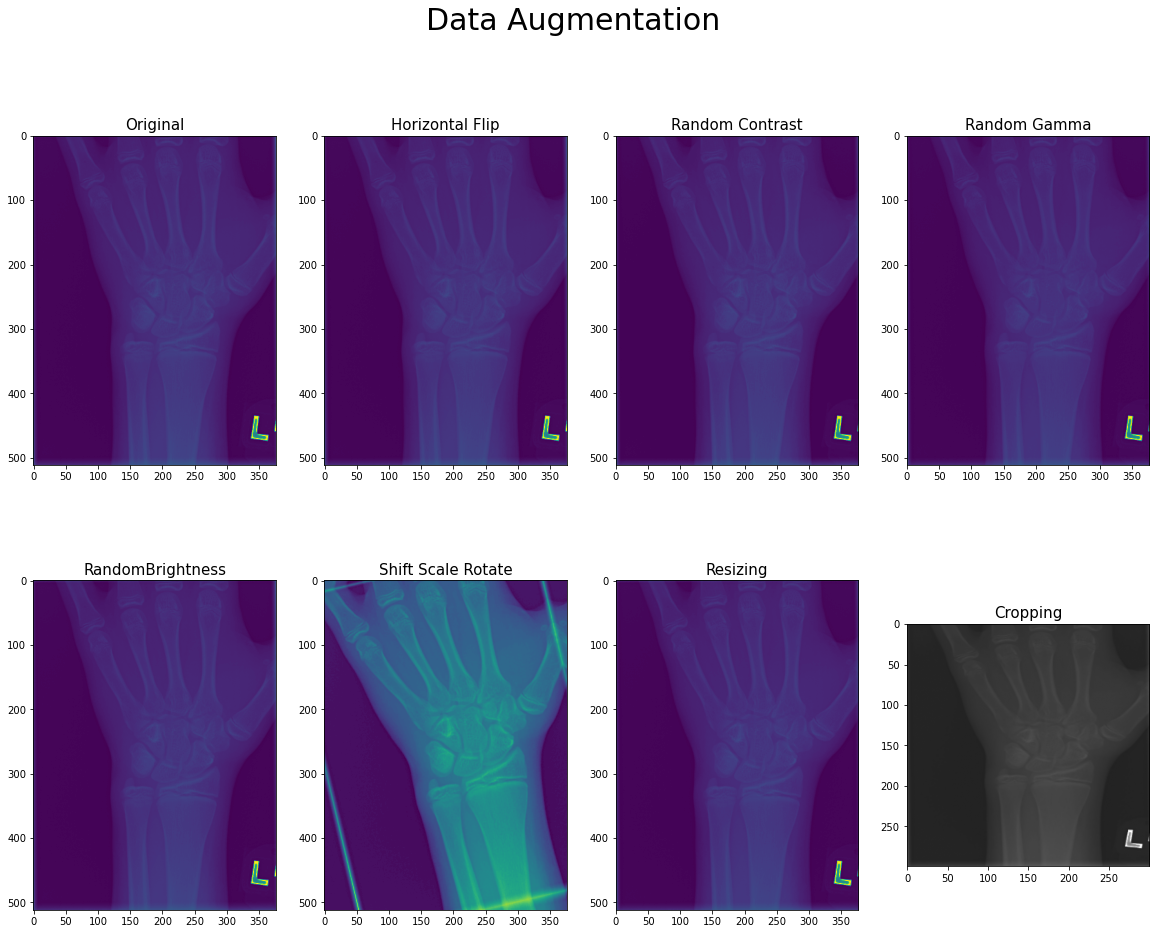

In [8]:
albumentation_list =  [
    HorizontalFlip(p=0.5),
    RandomContrast(limit=0.2, p=0.5),
    RandomGamma(gamma_limit=(80, 120), p=0.5),
    RandomBrightness(limit=0.2, p=0.5),
    ShiftScaleRotate(
        shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101, p=0.8), 
    ToFloat(max_value=255)
]
root='../input/mura-v11/'
chosen_image= imread(root+'MURA-v1.1/train/XR_WRIST/patient07988/study1_negative/image3.png')
img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)
img= resize(chosen_image,(300,300,3))
img_matrix_list.append(img)
img_matrix_list.append(crop_center(img,224,224))

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","Horizontal Flip","Random Contrast","Random Gamma","RandomBrightness",
               "Shift Scale Rotate","Resizing", "Cropping"]

def plot_multiple_img(img_matrix_list, title_list, ncols, main_title="Data Augmentation"):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=2, ncols=ncols, squeeze=True)
    fig.suptitle(main_title, fontsize = 30)
    #fig.subplots_adjust(wspace=0.3)
    #fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()
    
plot_multiple_img(img_matrix_list, titles_list, ncols = 4)

**Creating data generator for training and testiing with augmentation:**

In [9]:
class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size,transform) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.t= transform
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    x=[]
    for file in batch_x:
        img= imread(file)
        img= self.t(image=img)["image"]
        img= resize(img,(300,300,3))
        img= crop_center(img,224,224)
        x.append(img)
    x=np.array(x)/255.0
    y= np.array(batch_y)
    return x,y

**Some information about data:**

In [74]:
train_dir = "../input/mura-v11/MURA-v1.1/train"
validation_dir = '../input/mura-v11/MURA-v1.1/valid'
print("Total Training patients: ")
for i in os.listdir(train_dir) :
  print('Total Training patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/train/{}".format(i))))
print("\nTotal Validation patients: ")
for i in os.listdir(validation_dir) :
  print('Total Validation patients at {}:'.format(i),len(os.listdir("../input/mura-v11/MURA-v1.1/valid/{}".format(i))))

Total Training patients: 
Total Training patients at XR_WRIST: 3267
Total Training patients at XR_FINGER: 1865
Total Training patients at XR_SHOULDER: 2694
Total Training patients at XR_HAND: 1945
Total Training patients at XR_FOREARM: 865
Total Training patients at XR_HUMERUS: 587
Total Training patients at XR_ELBOW: 1711

Total Validation patients: 
Total Validation patients at XR_WRIST: 207
Total Validation patients at XR_FINGER: 166
Total Validation patients at XR_SHOULDER: 173
Total Validation patients at XR_HAND: 159
Total Validation patients at XR_FOREARM: 129
Total Validation patients at XR_HUMERUS: 132
Total Validation patients at XR_ELBOW: 152


**Getting data using the utility functions**

In [76]:
########################################
# One of the seven listed below:
"""
XR_ELBOW
XR_FINGER
XR_FOREARM
XR_HAND
XR_HUMERUS
XR_SHOULDER
XR_WRIST
""" 
# training_bone = 'XR_HUMERUS'
########################################

part='XR_WRIST' # part to work with
imgs,labels= filenames(part=part) # train data
vimgs,vlabels= filenames(part=part,train=False) # validation data

print('{} Training positive :'.format(part),labels.count('positive'),'\n','{} Training negative :'.format(part),labels.count('negative'))
training_data= labels.count('positive')+labels.count('negative')
print("Total Training Data at {}: ".format(part), training_data)
print('\n')
print('{} Validation positive :'.format(part),vlabels.count('positive'),'\n','{} Validation negative :'.format(part),vlabels.count('negative'))
validation_data= vlabels.count('positive')+vlabels.count('negative')
print("Total Validation Data: ", validation_data)

y_data= [0 if x=='positive' else 1 for x in labels]
y_data= keras.utils.to_categorical(y_data)
vy_data= [0 if x=='positive' else 1 for x in vlabels]
vy_data= keras.utils.to_categorical(vy_data)

XR_WRIST Training positive : 3987 
 XR_WRIST Training negative : 5765
Total Training Data at XR_WRIST:  9752


XR_WRIST Validation positive : 295 
 XR_WRIST Validation negative : 364
Total Validation Data:  659


**Calculate class-weight to avoid class-imbalance :**

In [11]:
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(y_data, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


**Create Training and Test daat generator**

In [12]:
batch_size = 32
imgs, y_data = shuffle(imgs, y_data)
#vimgs, vy_data = shuffle(vimgs, vy_data)
my_training_batch_generator = My_Custom_Generator(imgs, y_data, batch_size,AUGMENTATIONS_TRAIN)
my_validation_batch_generator = My_Custom_Generator(vimgs, vy_data, batch_size,AUGMENTATIONS_TEST)

**Training callbacks**

In [13]:
part='XR_WRIST'
checkpoint_path = "MURA_model@{}.h5".format(str(part))  
checkpoint_dir = os.path.dirname(checkpoint_path)
import json
json_log = open(str(part)+'_experiment_log_MURA.json', mode='wt', buffering=1)
my_callbacks = [
                    keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,  # Callback to save the Keras model or model weights at some frequency.
                                                    monitor='val_accuracy',
                                                    verbose=0,
                                                    save_best_only=True,
                                                    save_weights_only=False,
                                                    mode='auto',
                                                    save_freq = 'epoch'),
                    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',     # Reduce learning rate when a metric has stopped improving.
                                                      factor=0.1,
                                                      patience=3,
                                                      min_delta=0.001,
                                                      verbose=1,
                                                      min_lr=0.000000001),
                    keras.callbacks.LambdaCallback(
                                                    on_epoch_end=lambda epoch,
                                                    logs: json_log.write(json.dumps({'epoch': epoch, 
                                                                                     'train_loss': logs['loss'],
                                                                                     'val_loss': logs['val_loss'],
                                                                                      'weights': ""}) + '\n'), # dict(model.get_weights()) - np.array(model.get_weights()).tolist()
                                                    on_train_end=lambda logs: json_log.close()),
                    keras.callbacks.TensorBoard(log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                                                 histogram_freq=1, 
                                                 write_graph=True, 
                                                 write_images=False,    
                                                 update_freq='epoch', 
                                                 profile_batch=30, 
                                                 embeddings_freq=1,    
                                                 embeddings_metadata=None 
                                                 ),
                    keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=5,
                                                  mode="max",
                                                  baseline=None,
                                                  restore_best_weights=True,
)
                ]

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [14]:
# np.array(model.get_weights()).tolist()

In [15]:
my_callbacks,d_class_weights

([<tensorflow.python.keras.callbacks.ModelCheckpoint at 0x7fe5d1bc0fd0>,
 {0: 1.2229746676699274, 1: 0.8457935819601041})

**Create a model**

In [16]:
# Inception=tf.keras.applications.InceptionV3(include_top=False,input_shape=(224,224,3))#InceptionResNetV2
# #for layer in Inception.layers[:4]:
# #  layer.trainable=False
# input_image=keras.layers.Input((224,224,3))
# x=Inception (input_image)

# #x=keras.layers.GlobalAveragePooling2D()(x)
# x=keras.layers.Flatten()(x)
# #x=keras.layers.Dense(1024)(x)
# #x=keras.layers.Activation(activation='relu')(x)
# #x= keras.layers.Dropout(0.5)(x)
# x=keras.layers.Dense(256)(x)
# x=keras.layers.Activation(activation='relu')(x)
# x= keras.layers.Dropout(0.5)(x)
# x=keras.layers.Dense(2)(x)
# out=keras.layers.Activation(activation='softmax')(x)

# model=keras.Model(inputs=input_image,outputs=out)
# model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])
# print(model.summary())

Second model try:


In [17]:
##### Another model try: ########
base_model=keras.applications.InceptionV3(
#     weights='imagenet',  # Load weights pre-trained on ImageNet.,
    input_shape=(224,224,3),
    include_top=False) # Do not include the ImageNet classifier at the top

# odl from original
#for layer in base_model.layers[:4]:
#  layer.trainable=False

# Freeze base model
# base_model.trainable = False

# Create a new model on top
input_image=keras.layers.Input((224,224,3))

# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(input_image)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x=keras.layers.GlobalAveragePooling2D()(x)  ##### <-
# x=keras.layers.Flatten()(x)

x=keras.layers.Dense(1024)(x) ###
x=keras.layers.Activation(activation='relu')(x) ###
x= keras.layers.Dropout(0.5)(x) ###
x=keras.layers.Dense(256)(x)
x=keras.layers.Activation(activation='relu')(x)
x= keras.layers.Dropout(0.5)(x)
x=keras.layers.Dense(2)(x)
out=keras.layers.Activation(activation='softmax')(x)

model=keras.Model(inputs=input_image,outputs=out)
model.compile(optimizer=keras.optimizers.Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

87916544/87910968 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
activation_94 (Activation)   (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
______________________________________________________________

*  *Training*

In [18]:
history=model.fit_generator(generator=my_training_batch_generator,
                   steps_per_epoch = int(training_data // batch_size),
                   epochs = 40,
                   verbose = 1,
                   class_weight=d_class_weights,
                   validation_data = my_validation_batch_generator,
                   validation_steps = int(validation_data // batch_size),
                   callbacks=my_callbacks)

Epoch 1/40
304/304 [==============================] - 459s 2s/step - loss: 0.5204 - accuracy: 0.7433 - val_loss: 0.7175 - val_accuracy: 0.5156 - lr: 1.0000e-04
Epoch 2/40
304/304 [==============================] - 388s 1s/step - loss: 0.4192 - accuracy: 0.8234 - val_loss: 0.5100 - val_accuracy: 0.7578 - lr: 1.0000e-04
Epoch 3/40
304/304 [==============================] - 388s 1s/step - loss: 0.3869 - accuracy: 0.8441 - val_loss: 0.4861 - val_accuracy: 0.8313 - lr: 1.0000e-04
Epoch 4/40
304/304 [==============================] - 386s 1s/step - loss: 0.3598 - accuracy: 0.8546 - val_loss: 0.4510 - val_accuracy: 0.8078 - lr: 1.0000e-04
Epoch 5/40
304/304 [==============================] - 384s 1s/step - loss: 0.3441 - accuracy: 0.8667 - val_loss: 0.5982 - val_accuracy: 0.7469 - lr: 1.0000e-04
Epoch 6/40
304/304 [==============================] - 385s 1s/step - loss: 0.3306 - accuracy: 0.8689 - val_loss: 0.5196 - val_accuracy: 0.8344 - lr: 1.0000e-04
Epoch 7/40
304/304 [====================

In [33]:
# %load_ext tensorboard
# %tensorboard --logdir logs/fit
# !kill 4805

In [26]:
# list all data in history
print(history.history.keys())
# history.history

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


**summarize history for accuracy**

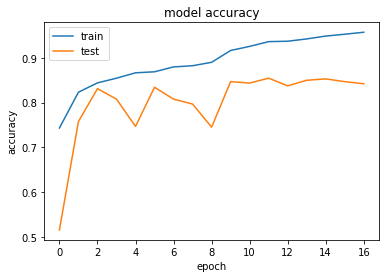

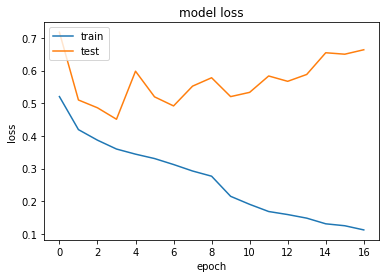

In [27]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Extracting some log to csv and json forms**

In [29]:
# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [67]:
# model.get_weights()

In [68]:
# convert the model.get_weights() dict to a pandas DataFrame:     
model_weights_df = pd.DataFrame(model.get_weights()) 

# save to json:  
model_weights_file = 'XR_WRIST-model_weights.json' 
with open(hist_json_file, mode='w') as f:
    model_weights_df.to_json(f)

# or save to csv: 
model_weights_file = 'XR_WRIST-model_weights.csv'
with open(hist_csv_file, mode='w') as f:
    model_weights_df.to_csv(f)

In [78]:
# from distutils.dir_util import copy_tree
# fromDirectory = '../kaggle/working'
# toDirectory = '../tempTry'
# copy_tree(fromDirectory,toDirectory)

In [48]:
# path = 'MURA_model@XR_WRIST-2.h5' 
# model.save("MURA_model@XR_WRIST.h5")

**Evaluate the performance by cohen's kappa score**

In [54]:
# model.save('MURA_model@XR_WRIST.h5')
m = tfa.metrics.CohenKappa(num_classes=2,sparse_labels=False)
# model=tf.keras.models.load_model(path)
y_pred=  model.predict(my_validation_batch_generator)

yp2 = np.argmax(y_pred,axis = 1)
ya2 = np.argmax(vy_data,axis = 1)
print(y_pred.shape,vy_data.shape)
m.update_state(ya2, yp2)
print('Final result: ', m.result().numpy())

(659, 2) (659, 2)
Final result:  0.70401907


In [55]:
vy_data2 = np.argmax(vy_data,axis=1)
vy_data2.shape

(659,)

In [56]:
yp2.shape

(659,)

In [57]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sn

**Confusion matrix for validation data:**

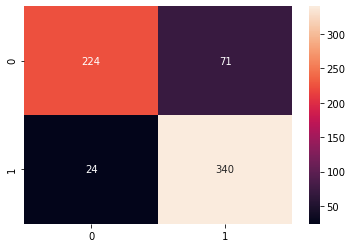

In [58]:
cm = confusion_matrix(vy_data2,yp2)
sn.heatmap(cm,annot=True,fmt='d')
plt.show()

In [59]:
print(classification_report(vy_data2,yp2))

              precision    recall  f1-score   support

           0       0.90      0.76      0.83       295
           1       0.83      0.93      0.88       364

    accuracy                           0.86       659
   macro avg       0.87      0.85      0.85       659
weighted avg       0.86      0.86      0.85       659



**Confusion matrix for trainning data**

In [62]:
y_pred=  model.predict(my_training_batch_generator)

In [63]:
yp3 = np.argmax(y_pred,axis=1)
y_true3 = np.argmax(y_data,axis=1)

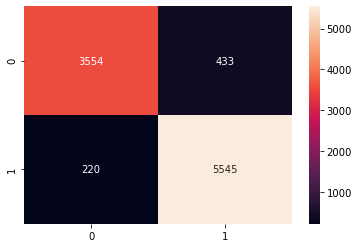

In [64]:
cm2 = confusion_matrix(y_true3,yp3)
sn.heatmap(cm2,annot=True,fmt='d')
plt.show()

In [65]:
print(classification_report(y_true3,yp3))

              precision    recall  f1-score   support

           0       0.94      0.89      0.92      3987
           1       0.93      0.96      0.94      5765

    accuracy                           0.93      9752
   macro avg       0.93      0.93      0.93      9752
weighted avg       0.93      0.93      0.93      9752

